<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/Rule_based_method_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from tkinter.constants import NONE

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_excel("/content/sample_data/robust_test_dataset.xlsx")
# df_stuck_pipe = df[df["dataset"] == "stuck pipe"]
# df_pbu = df[df["dataset"] == "pressure build-up"]
# df_gas_shows = df[df["dataset"] == "gas shows"]
# df_gbearing = df[df["dataset"] == "gas bearing"]
# df_fc = df[df["dataset"] == "fluid communication"]
# df_op = df[df["dataset"] == "overpressure"]
df_oil_shows = df[df["dataset"] == "oil show"]
# df_sand = df[df["dataset"] == "sand_production"]

df = df_oil_shows

In [3]:
# Define the topics as flexible terms (subwords or whole words)
# topics = ["gas shows" , "oil show", "overpressure", "fluid communication" , "gas bearing" , "h2s" , "co2" , "stuck pipe" , "pressure build up", "sand production"]
topics = ["oil show"]

# Define the negation terms pattern with case-insensitivity
negation_terms = r'(?i)(?:(?<=\s)|^)(no|non|unlikely|none|not|nor|without|lack|rather)(?=\s|$|\b)'

# Initialize a WordNet lemmatizer
# lemmatizer = WordNetLemmatizer()

# Define a custom lemmatization rule to replace "ized" with "e"
def custom_lemmatizer(word):
    if word.endswith("ized"):
        return re.sub(r'ized$', 'e', word)
    elif word.endswith("ing"):
        return re.sub(r'ing$', 'e', word)
    else:
        return word
        # return lemmatizer.lemmatize(word)

# Initialize a list to store selected sentences
selected_sentences = []

# Initialize a flag to check for both topic terms and negation terms
both_detected = False

# Iterate over the 'date' column and apply .lower() only to string values
for index, row in df.iterrows():
    if isinstance(row['doc_text_original'], str):
        # Apply .lower() to string values
        text = row['doc_text_original'].lower()  # Convert to lowercase

    # Tokenize the text into sentences using NLTK's sent_tokenize
    sentences = sent_tokenize(text)

    # Initialize flags to check for both topic terms and negation terms
    topic_found = False
    negation_detected = False

    for sentence in sentences:

      # remove apostrophes from string
      sentence = sentence.replace("'", "")

      # Tokenize the sentence into words
      words = word_tokenize(sentence)

      # Lemmatize each word using the custom lemmatizer
      lemmatized_words = [custom_lemmatizer(word) for word in words]

      # Join the lemmatized words back into a sentence
      lemmatized_sentence = ' '.join(lemmatized_words)

      # Check if the sentence contains any of the specified topics (partial matches)
      for topic_pattern in topics:
        words = topic_pattern.split()

      if len(words) >= 2:
        # Initialize an empty pattern string
        pattern_string = r'(?i)(?:(?<=\s)|^)'

        # Loop through the words and add them to the pattern
        for i in range(len(words)):
            pattern_string += re.escape(words[i])

            # Add optional characters (like hyphens) between words (except for the last word)
            if i < len(words) - 1:
                pattern_string += r'\s*-*\s*'

        # Add the closing part of the pattern
        pattern_string += r'(?=\s|$)'

        # Compile the regex pattern
        topic_pattern = re.compile(pattern_string)

        if re.search(topic_pattern, lemmatized_sentence.lower()):
            topic_found = True
            break

        """
        if len(words) >= 2:
          # Define the regex pattern for two-word topics with optional characters in the middle
          two_word_topic_pattern = re.compile(rf'(?i)(?:(?<=\s)|^)({re.escape(words[0])}\s*-*\s*{re.escape(words[1])})(?=\s|$)')
          if re.search(two_word_topic_pattern, lemmatized_sentence.lower()):
            topic_found = True
            break
        """

      else:
          single_pattern = rf'(?i)(?:(?<=\s)|^)({re.escape(words[0])})(?=\s|$)'
          if re.search(single_pattern, lemmatized_sentence.lower()):
              topic_found = True
              break

      # Check if the lemmatized sentence contains negation terms
      if re.search(negation_terms, lemmatized_sentence.lower()):
          negation_detected = True
      else:
          negation_detected = False

      # If a topic term is found and either no negation terms are found or negation_detected is False, append the sentence
      if (topic_found is True) and (negation_detected is True):
          selected_sentences.append(lemmatized_sentence)
          both_detected = True
          break

      elif (topic_found is True) and (negation_detected is False):
          selected_sentences.append(lemmatized_sentence)
          both_detected = True
          break


    # If no sentence with both topic and negation terms is found, append the first sentence without a negation term
    if not both_detected or topic_found is False:
        selected_sentences.append(lemmatized_sentence)



 # Add the selected_sentences as a new column named 'selected_sentence'
df['selected_sentence'] = selected_sentences

print(len(selected_sentences))


101


In [4]:
# Determine the prediction (0 or 1) based on the presence of negation terms in selected_sentence
for index, row in df.iterrows():
    selected_sentence = row['selected_sentence']

    if selected_sentence is not None:
        # Check if the lemmatized sentence contains negation terms
        if re.search(negation_terms, selected_sentence.lower()):
            prediction = 0  # Negation terms found, set the prediction to 0
        else:
            prediction = 1  # No negation terms found, set the prediction to 1
    else:
        prediction = 0  # Handle the case where selected_sentence is None

    df.at[index, 'predicted'] = prediction

# Print the DataFrame with the 'label' column
df[['doc_text_original', 'selected_sentence', 'label_code', 'predicted']]

,doc_text_original,selected_sentence,label_code,predicted
2060,". T no oil show, no fluor. Gas 800 to 300 uni""...","t no oil show , no fluor .",0,0.0
2061,Hydrocarbon Shows: Poor oil show were encounte...,hydrocarbon shows : poor oil show were encount...,1,1.0
2062,Hod Formation: 9520-10141 ft (2901.7-3091.0 m)...,trace oil show occurred from 9965-10000 ft ( 3...,1,1.0
2063,"with oil show, as above. '","with oil show , as above .",1,1.0
2064,Grade 1-2 oil show. ',grade 1-2 oil show .,1,1.0
...,...,...,...,...
2156,21 21A 22 22A 23 23A 24 24A 25 25A 26 26A 27 2...,"wide , ft , dull , yelwh t/t 20 % patchy grny/...",1,0.0
2157,"""used to calculate the geochemical Altbough th...",the data in table 5 indicates ihat the the two...,1,1.0
2158,"""used to calculate the geochemical Altbough th...",the data in table 5 indicates ihat the the two...,1,1.0
2159,lower levels of these unknown compounds is not...,results suggest that the sample represents an ...,1,1.0


**Negation Prediction with SpaCy Negex package**

In [5]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
# Import the necessary library for sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Initialize a list to store predictions (0 for negation, 1 for non-negation)
predictions_negex = []

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    selected_sentence = row['selected_sentence']

    if selected_sentence is not None:
        # Use SentimentIntensityAnalyzer to get sentiment polarity score
        sentiment_score = sia.polarity_scores(selected_sentence)

        # Determine the prediction based on the sentiment score
        if sentiment_score['compound'] < 0:
            prediction_negex = 0  # Negative sentiment, set prediction to 0 (negation)
        else:
            prediction_negex = 1  # Positive or neutral sentiment, set prediction to 1 (non-negation)
    else:
        prediction_negex = 0  # Handle the case where selected_sentence is None

    predictions_negex.append(prediction_negex)

# Add the predictions_negex as a new column named 'prediction_negex'
df['prediction_negex'] = predictions_negex

# Print the DataFrame with the 'label' column and the new 'prediction_negex' column
# df[['doc_text_original', 'selected_sentence', 'label_code', 'predicted', 'prediction_negex']]


## **Prediction Evaluation**

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

accuracy_values = [0.26,0.23,0.89,0.71,0.69,0.71,0.66]
precision_values = [0.48,0.55,0.70,0.52,0.64,0.72,0.55]
recall_values = [0.46,0.52,0.94,0.63,0.65,0.76,0.61]
f1_values = [0.26,0.22,0.75,0.47,0.64,0.70,0.52]


In [14]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
# y_pred = df['prediction_negex']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Append metric values to the respective lists
accuracy_values.append(accuracy)
precision_values.append(precision)
recall_values.append(recall)
f1_values.append(f1)

print(accuracy, precision, recall, f1)

0.8613861386138614 0.7017857142857142 0.8424242424242425 0.7400735294117646


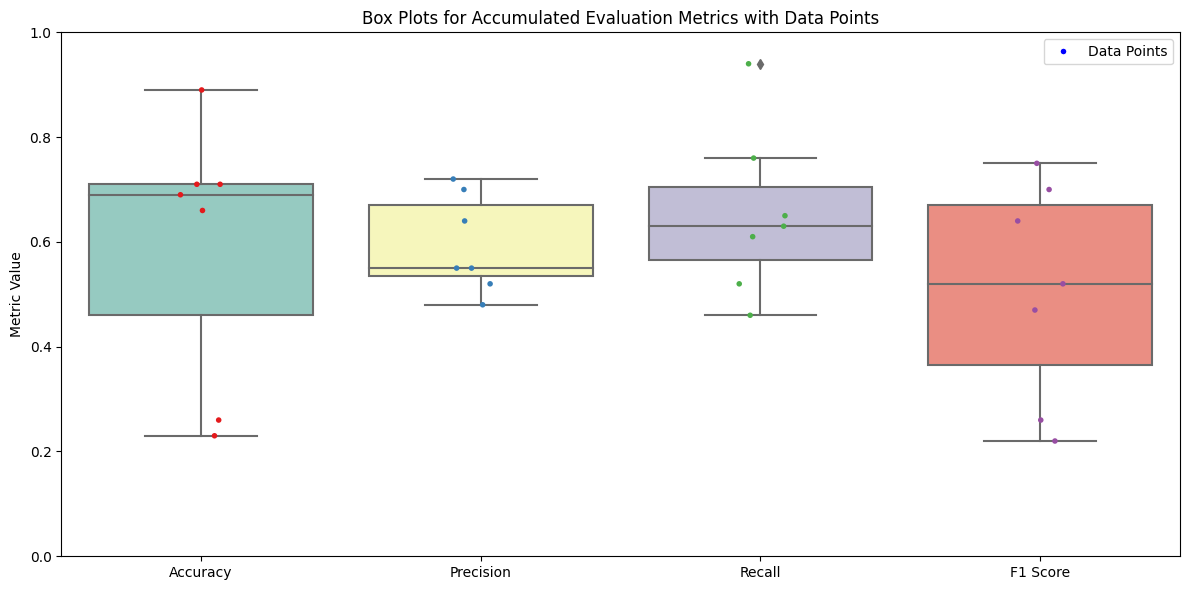

In [17]:
# Create a box plot for the accumulated evaluation metrics
metric_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
metric_values = [accuracy_values, precision_values, recall_values, f1_values]

plt.figure(figsize=(12, 6))
sns.boxplot(data=metric_values, orient="v", palette="Set3")
sns.stripplot(data=metric_values, orient="v", palette="Set1", size=4, jitter=True)

# Add legends
legends = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=5, label='Data Points')]
plt.legend(handles=legends, loc='upper right')
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1

plt.xticks(range(4), metric_names)
plt.ylabel("Metric Value")
plt.title("Box Plots for Accumulated Evaluation Metrics with Data Points")
plt.tight_layout()
plt.show()

In [10]:
# Assuming 'df' is your DataFrame
df.to_excel("dataset_gb.xlsx", index=False)